In [1]:
from keras.models import model_from_json
from keras.utils import plot_model
import os
root = '.'
dataset_dir = os.path.join(root, 'generated', 'create_sample_extractor3_1')

Using TensorFlow backend.


In [2]:
"""
Open Model
"""
# load json and create model
json_file = open(os.path.join(dataset_dir, 'modelz2.json'), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(os.path.join(dataset_dir, "extractorz2_epoch-76_loss-0.9559_val_loss-2.1267.h5"))
print("Loaded model from disk")
plot_model(loaded_model, show_shapes=True, to_file=os.path.join(dataset_dir, 'loaded_modelz2.jpg'))

Loaded model from disk


In [3]:
"""
Data Preparation
"""
import h5py
import numpy as np
import pandas as pd
from keras.utils import *


def logitize_labels(labels):
    labels = np.array(labels)
    # Convert S2 labels to logits
    logits_s1_0 = np_utils.to_categorical(labels[:, 1], 3)
    logits_s1_1 = np_utils.to_categorical(labels[:, 2], 27)
    logits_s1_2 = np_utils.to_categorical(labels[:, 3], 27)
    s1_logits = np.hstack([logits_s1_0, logits_s1_1, logits_s1_2])
    
    # Convert S2 labels to logits
    logits_s2_0 = np_utils.to_categorical(labels[:, 4], 5) 
    logits_s2_1 = np_utils.to_categorical(labels[:, 5], 11) 
    logits_s2_2 = np_utils.to_categorical(labels[:, 6], 11) 
    logits_s2_3 = np_utils.to_categorical(labels[:, 7], 11) 
    logits_s2_4 = np_utils.to_categorical(labels[:, 8], 11)
    s2_logits = np.hstack([logits_s2_0, logits_s2_1, logits_s2_2, logits_s2_3, logits_s2_4])
    
    # Convert S3 labels to logits
    logits_s3_0 = np_utils.to_categorical(labels[:, 9], 4)
    logits_s3_1 = np_utils.to_categorical(labels[:, 10], 27)
    logits_s3_2 = np_utils.to_categorical(labels[:, 11], 27)
    logits_s3_3 = np_utils.to_categorical(labels[:, 12], 27)
    s3_logtis = np.hstack([logits_s3_0, logits_s3_1, logits_s3_2, logits_s3_3])
    
    return np.hstack([s1_logits, s2_logits, s3_logtis]) 
    
    
def initialize_data(dataset_dir):
    # Dataset preparation
    dataset_file = os.path.join(dataset_dir, 'dataset.h5')
    
    f = h5py.File(dataset_file, 'r')
    images = np.array(f['images'])
    shapes = np.array(f['shapes'])
    dataset = []
    for i in range(len(images)):
        dataset.append(images[i].reshape(shapes[i]))
    
    # Labels preparation
    labels_file = os.path.join(dataset_dir, 'label.csv')
    labels = pd.read_csv(labels_file)
    labels = logitize_labels(labels)
    return dataset, labels


test_dataset, test_labels = initialize_data(dataset_dir=os.path.join(dataset_dir, 'test_dataset'))
print('Test dataset : ', len(test_dataset))
print('Test labels : ', test_labels.shape)



Test dataset :  2000
Test labels :  (2000, 191)


In [4]:

"""
Sanity Checking
"""
from matplotlib import pyplot as plt

label_helper = {'m_s1': slice(0, 3), 
                's1_1': slice(3, 30),
                's1_2': slice(30, 57),
                'm_s2': slice(57, 62),
                's2_1': slice(62, 73), 
                's2_2': slice(73, 84), 
                's2_3': slice(84, 95),
                's2_4': slice(95, 106),
                'm_s3': slice(106, 110), 
                's3_1': slice(110, 137),
                's3_2': slice(137, 164), 
                's3_3': slice(164, 191)}

def logits_decoder(label):
    # Convert label to readable character
    s1_0 = label[0:3]
    s1_1 = label[3:30]
    s1_2 = label[30:57]
    
    s2_0 = label[57:62]
    s2_1 = label[62:73]
    s2_2 = label[73:84]
    s2_3 = label[84:95]
    s2_4 = label[95:106]
    
    s3_0 = label[106:110]
    s3_1 = label[110:137]
    s3_2 = label[137:164]
    s3_3 = label[164:191]
    
    s1_0 = np.argmax(s1_0)
    s1_1 = np.argmax(s1_1)
    s1_2 = np.argmax(s1_2)
    
    s2_0 = np.argmax(s2_0)
    s2_1 = np.argmax(s2_1)
    s2_2 = np.argmax(s2_2)
    s2_3 = np.argmax(s2_3)
    s2_4 = np.argmax(s2_4)
    
    s3_0 = np.argmax(s3_0)
    s3_1 = np.argmax(s3_1)
    s3_2 = np.argmax(s3_2)
    s3_3 = np.argmax(s3_3)
    
    s1 = [s1_0, s1_1, s1_2]
    s2 = [s2_0, s2_1, s2_2, s2_3, s2_4]
    s3 = [s3_0, s3_1, s3_2, s3_3]
    return s1, s2, s3


def label_decoder(label):
    """
    Label Decoder
    Output real value from the label
    e.g 'AE 2343 PY'
    """
    
    label = logits_decoder(label)
    s1 = ''
    s1 += chr(label[2] + 64) if label[2] > 0 else ''
    s1 += chr(label[3] + 64) if label[3] > 0 else ''
    
    s2 = ''
    s2 += str(label[5] - 1) if label[5]-1 > -1 else ''
    s2 += str(label[6] - 1) if label[6]-1 > -1 else ''
    s2 += str(label[7] - 1) if label[7]-1 > -1 else ''
    s2 += str(label[8] - 1) if label[8]-1 > -1 else ''
    
    s3 = ''
    s3 += chr(label[10] + 64) if label[10] > 0 else '' 
    s3 += chr(label[11] + 64) if label[11] > 0 else '' 
    s3 += chr(label[12] + 64) if label[12] > 0 else ''
    
    return s1 + ' ' + s2 + ' ' + s3  


select = 24
plt.imshow(test_dataset[select])
# Check S1
print('s1 : ', str(logits_decoder(test_labels[select])[0]))
print(str(test_labels[select, label_helper['m_s1']]))
print(str(test_labels[select, label_helper['s1_1']]))
print(str(test_labels[select, label_helper['s1_2']]))

# Check S2
print('s2 : ', str(logits_decoder(test_labels[select])[1]))
print(str(test_labels[select, label_helper['m_s2']]))
print(str(test_labels[select, label_helper['s2_1']]))
print(str(test_labels[select, label_helper['s2_2']]))
print(str(test_labels[select, label_helper['s2_3']]))
print(str(test_labels[select, label_helper['s2_4']]))

# Check S3
print('s3 : ', str(logits_decoder(test_labels[select])[2]))
print(str(test_labels[select, label_helper['m_s3']]))
print(str(test_labels[select, label_helper['s3_1']]))
print(str(test_labels[select, label_helper['s3_2']]))
print(str(test_labels[select, label_helper['s3_3']]))


s1 :  [0, 0, 0]
[1. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
s2 :  [0, 0, 0, 0, 0]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
s3 :  [0, 0, 0, 0]
[1. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


In [5]:
"""
Image resizing
"""
import cv2 as cv2
model_input_dim = (200, 61)
def image_resizer(im, dim):
    image = cv2.resize(im, dim, interpolation=cv2.INTER_LINEAR)
    return image

# Resize semua dataset untuk inferencing
im_dim = (200, 61)
dataset_resized = []
for i in range(len(test_dataset)):
    dataset_resized.append(image_resizer(test_dataset[i], im_dim))
dataset_resized = np.array(dataset_resized)
dataset_resized.shape

(2000, 61, 200, 3)

In [28]:
"""
Test Evaluation
"""
"""
Plate Loss function
"""

from keras import backend as K
from keras.optimizers import *

def plate_loss(y_true, y_pred):
    loss_s1_0 = K.mean(K.categorical_crossentropy(y_true[:, label_helper['m_s1']], y_pred[:, label_helper['m_s1']]))
    loss_s1_1 = K.mean(K.categorical_crossentropy(y_true[:, label_helper['s1_1']], y_pred[:, label_helper['s1_1']]))
    loss_s1_2 = K.mean(K.categorical_crossentropy(y_true[:, label_helper['s1_2']], y_pred[:, label_helper['s1_2']]))
    
    loss_s2_0 = K.mean(K.categorical_crossentropy(y_true[:, label_helper['m_s2']], y_pred[:, label_helper['m_s2']]))
    loss_s2_1 = K.mean(K.categorical_crossentropy(y_true[:, label_helper['s2_1']], y_pred[:, label_helper['s2_1']]))
    loss_s2_2 = K.mean(K.categorical_crossentropy(y_true[:, label_helper['s2_2']], y_pred[:, label_helper['s2_2']]))
    loss_s2_3 = K.mean(K.categorical_crossentropy(y_true[:, label_helper['s2_3']], y_pred[:, label_helper['s2_3']]))
    loss_s2_4 = K.mean(K.categorical_crossentropy(y_true[:, label_helper['s2_4']], y_pred[:, label_helper['s2_4']]))
    
    loss_s3_0 = K.mean(K.categorical_crossentropy(y_true[:, label_helper['m_s3']], y_pred[:, label_helper['m_s3']]))
    loss_s3_1 = K.mean(K.categorical_crossentropy(y_true[:, label_helper['s3_1']], y_pred[:, label_helper['s3_1']]))
    loss_s3_2 = K.mean(K.categorical_crossentropy(y_true[:, label_helper['s3_2']], y_pred[:, label_helper['s3_2']]))
    loss_s3_3 = K.mean(K.categorical_crossentropy(y_true[:, label_helper['s3_3']], y_pred[:, label_helper['s3_3']]))
    
    loss_s1 = loss_s1_0 + loss_s1_1 + loss_s1_2
    loss_s2 = loss_s2_0 + loss_s2_1 + loss_s2_2 + loss_s2_3 + loss_s2_4
    loss_s3 = loss_s3_0 + loss_s3_1 + loss_s3_2 + loss_s3_3
    return loss_s1 + loss_s2 + loss_s3

def character_acc(y_true, y_pred):
    s1_0 = K.mean(K.equal(y_true[:, label_helper['m_s1']], y_pred[:, label_helper['m_s1']]))
    s1_1 = K.mean(K.equal(y_true[:, label_helper['s1_1']], y_pred[:, label_helper['s1_1']]))
    s1_2 = K.mean(K.equal(y_true[:, label_helper['s1_2']], y_pred[:, label_helper['s1_2']]))
    
    s2_0 = K.mean(K.equal(y_true[:, label_helper['m_s2']], y_pred[:, label_helper['m_s2']]))
    s2_1 = K.mean(K.equal(y_true[:, label_helper['s2_1']], y_pred[:, label_helper['s2_1']]))
    s2_2 = K.mean(K.equal(y_true[:, label_helper['s2_2']], y_pred[:, label_helper['s2_2']]))
    s2_3 = K.mean(K.equal(y_true[:, label_helper['s2_3']], y_pred[:, label_helper['s2_3']]))
    s2_4 = K.mean(K.equal(y_true[:, label_helper['s2_4']], y_pred[:, label_helper['s2_4']]))
    
    s3_0 = K.mean(K.equal(y_true[:, label_helper['m_s3']], y_pred[:, label_helper['m_s3']]))
    s3_1 = K.mean(K.equal(y_true[:, label_helper['s3_1']], y_pred[:, label_helper['s3_1']]))
    s3_2 = K.mean(K.equal(y_true[:, label_helper['s3_2']], y_pred[:, label_helper['s3_2']]))
    s3_3 = K.mean(K.equal(y_true[:, label_helper['s3_3']], y_pred[:, label_helper['s3_3']]))
    
    s1 = s1_0 + s1_1 + s1_2
    s2 = s2_0 + s2_1 + s2_2 + s2_3 + s2_4
    s3 = s3_0 + s3_1 + s3_2 + s3_3
    return s1 + s2 + s3
    
def character_acc2(y_true, y_pred):
    s1_0 = K.equal(K.argmax(y_true[:, label_helper['m_s1']]), K.argmax(y_pred[:, label_helper['m_s1']]))
    s1_1 = K.equal(K.argmax(y_true[:, label_helper['s1_1']]), K.argmax(y_pred[:, label_helper['s1_1']]))
    s1_2 = K.equal(K.argmax(y_true[:, label_helper['s1_2']]), K.argmax(y_pred[:, label_helper['s1_2']]))
    
    s2_0 = K.equal(K.argmax(y_true[:, label_helper['m_s2']]), K.argmax(y_pred[:, label_helper['m_s2']]))
    s2_1 = K.equal(K.argmax(y_true[:, label_helper['s2_1']]), K.argmax(y_pred[:, label_helper['s2_1']]))
    s2_2 = K.equal(K.argmax(y_true[:, label_helper['s2_2']]), K.argmax(y_pred[:, label_helper['s2_2']]))
    s2_3 = K.equal(K.argmax(y_true[:, label_helper['s2_3']]), K.argmax(y_pred[:, label_helper['s2_3']]))
    s2_4 = K.equal(K.argmax(y_true[:, label_helper['s2_4']]), K.argmax(y_pred[:, label_helper['s2_4']]))
    
    s3_0 = K.equal(K.argmax(y_true[:, label_helper['m_s3']]), K.argmax(y_pred[:, label_helper['m_s3']]))
    s3_1 = K.equal(K.argmax(y_true[:, label_helper['s3_1']]), K.argmax(y_pred[:, label_helper['s3_1']]))
    s3_2 = K.equal(K.argmax(y_true[:, label_helper['s3_2']]), K.argmax(y_pred[:, label_helper['s3_2']]))
    s3_3 = K.equal(K.argmax(y_true[:, label_helper['s3_3']]), K.argmax(y_pred[:, label_helper['s3_3']]))
    
    s1 = K.mean(s1_0) + K.mean(s1_1) + K.mean(s1_2)
    s2 = K.mean(s2_0) + K.mean(s2_1) + K.mean(s2_2) + K.mean(s2_3) + K.mean(s2_4)
    s3 = K.mean(s3_0) + K.mean(s3_1) + K.mean(s3_2) + K.mean(s3_3)
    # return s1 + s2 + s3
    return (s1+s2+s3)/12

def number_loss(y_true, y_pred):
    loss_s2_0 = K.mean(K.categorical_crossentropy(y_true[:, 0:5], y_pred[:, 0:5]))
    loss_s2_1 = K.mean(K.categorical_crossentropy(y_true[:, 5:16], y_pred[:, 5:16]))
    loss_s2_2 = K.mean(K.categorical_crossentropy(y_true[:, 16:27], y_pred[:, 16:27]))
    loss_s2_3 = K.mean(K.categorical_crossentropy(y_true[:, 27:38], y_pred[:, 27:38]))
    loss_s2_4 = K.mean(K.categorical_crossentropy(y_true[:, 38:49], y_pred[:, 38:49]))
    return loss_s2_0 + loss_s2_1 + loss_s2_2 + loss_s2_3 + loss_s2_4

sgd = SGD(lr=0.0001, momentum=0.8)
loaded_model.compile(optimizer=sgd, loss=plate_loss, metrics=[character_acc2])

loaded_model.evaluate(x=dataset_resized, y=test_labels)


  32/2000 [..............................] - ETA: 2:33

  64/2000 [..............................] - ETA: 1:21

  96/2000 [>.............................] - ETA: 57s 

 128/2000 [>.............................] - ETA: 45s

 160/2000 [=>............................] - ETA: 37s

 192/2000 [=>............................] - ETA: 32s

 224/2000 [==>...........................] - ETA: 29s

 256/2000 [==>...........................] - ETA: 26s

 288/2000 [===>..........................] - ETA: 24s

 320/2000 [===>..........................] - ETA: 22s

 352/2000 [====>.........................] - ETA: 20s

 384/2000 [====>.........................] - ETA: 19s

 416/2000 [=====>........................] - ETA: 18s

 448/2000 [=====>........................] - ETA: 17s

 480/2000 [======>.......................] - ETA: 16s

 512/2000 [======>.......................] - ETA: 15s

 544/2000 [=======>......................] - ETA: 15s

 576/2000 [=======>......................] - ETA: 14s

 608/2000 [========>.....................] - ETA: 13s

 640/2000 [========>.....................] - ETA: 13s

 672/2000 [=========>....................] - ETA: 12s

 704/2000 [=========>....................] - ETA: 12s

 736/2000 [==========>...................] - ETA: 11s

 768/2000 [==========>...................] - ETA: 11s

 800/2000 [===========>..................] - ETA: 10s

 832/2000 [===========>..................] - ETA: 10s

 864/2000 [===========>..................] - ETA: 10s

 896/2000 [============>.................] - ETA: 9s 

 928/2000 [============>.................] - ETA: 9s

 960/2000 [=============>................] - ETA: 8s

 992/2000 [=============>................] - ETA: 8s

1024/2000 [==============>...............] - ETA: 8s

1056/2000 [==============>...............] - ETA: 7s

1088/2000 [===============>..............] - ETA: 7s

1120/2000 [===============>..............] - ETA: 7s

1152/2000 [================>.............] - ETA: 6s

1184/2000 [================>.............] - ETA: 6s

1216/2000 [=================>............] - ETA: 6s

1248/2000 [=================>............] - ETA: 6s

1280/2000 [==================>...........] - ETA: 5s

1312/2000 [==================>...........] - ETA: 5s

1344/2000 [===================>..........] - ETA: 5s

1376/2000 [===================>..........] - ETA: 4s

1408/2000 [====================>.........] - ETA: 4s

1440/2000 [====================>.........] - ETA: 4s

1472/2000 [=====================>........] - ETA: 4s

1504/2000 [=====================>........] - ETA: 3s

1536/2000 [======================>.......] - ETA: 3s

1568/2000 [======================>.......] - ETA: 3s

1600/2000 [=======================>......] - ETA: 3s

1632/2000 [=======================>......] - ETA: 2s

1664/2000 [=======================>......] - ETA: 2s

1696/2000 [========================>.....] - ETA: 2s

1728/2000 [========================>.....] - ETA: 2s

1760/2000 [=========================>....] - ETA: 1s

1792/2000 [=========================>....] - ETA: 1s

1824/2000 [==========================>...] - ETA: 1s

1856/2000 [==========================>...] - ETA: 1s

1888/2000 [===========================>..] - ETA: 0s

1920/2000 [===========================>..] - ETA: 0s

1952/2000 [============================>.] - ETA: 0s

1984/2000 [============================>.] - ETA: 0s

2000/2000 [==============================] - 15s 7ms/step


[2.318086928367615, 0.9532083501815796]

In [8]:
"""
Save model2 (architecture and weights in one file)
"""
loaded_model.save(os.path.join(dataset_dir, 'model2_y1.h5'))
print("Saved model")

Saved model


In [8]:
y_pred = loaded_model.predict(dataset_resized)

Ground truth :  ([2, 25, 1], [4, 5, 6, 9, 8], [3, 24, 6, 13])
Prediction :  ([2, 25, 1], [4, 5, 6, 9, 2], [3, 24, 6, 8])


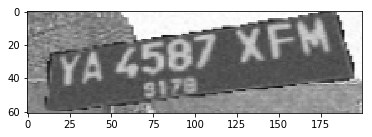

In [9]:
from matplotlib import pyplot as plt
sel = 99


print('Ground truth : ', str(logits_decoder(test_labels[sel])))
print('Prediction : ', str(logits_decoder(y_pred[sel])))
# print(str(y_pred[sel, 0:5]))
# print(str(y_pred[sel, 5:16]))
# print(str(y_pred[sel, 16:27]))
# print(str(y_pred[sel, 27:38]))
# print(str(y_pred[sel, 38:49]))
plt.imshow(dataset_resized[sel])

In [9]:
"""
Prepare for inference predict
"""
from PIL import Image
inference_image_dir = os.path.join(os.path.join(dataset_dir, 'inference'))
inference_image_filenames = os.listdir(inference_image_dir)
inference_image = []
for filename in inference_image_filenames:
    path = os.path.join(inference_image_dir, filename)
    image = np.array(Image.open(path))
    image = image_resizer(image, im_dim)
    inference_image.append(image)
inference_image = np.array(inference_image)
plt.imshow(inference_image[0])

FileNotFoundError: [Errno 2] No such file or directory: './generated/create_sample_extractor3_1/inference'

In [27]:
y_inf = loaded_model.predict(inference_image)

Prediction :  ([2, 1, 4], [4, 9, 9, 7, 2], [3, 20, 15, 0])


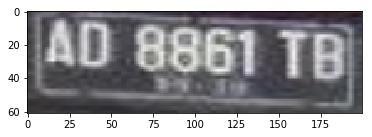

In [29]:
sel = 19

print('Prediction : ', str(logits_decoder(y_inf[sel])))
# print('Ground truth : ', str(logits_decoder(labels[sel])))
# print(str(y_pred[sel, 0:5]))
# print(str(y_pred[sel, 5:16]))
# print(str(y_pred[sel, 16:27]))
# print(str(y_pred[sel, 27:38]))
# print(str(y_pred[sel, 38:49]))
plt.imshow(inference_image[sel])


In [27]:
loaded_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 61, 200, 3)   0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 67, 206, 3)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 31, 100, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 31, 100, 64)  256         conv1[0][0]                      
__________________________________________________________________________________________________
activation